# ML_CyberAttack Predictor project


Import libraries :
link to ua-parser library : https://github.com/ua-parser/uap-python



In [239]:
import pandas as pd
from uaparser import UAParser as parse_ua


# DATA CLEAN

In [240]:
dataset_path = 'Data/cybersecurity_attacks.csv'
df = pd.read_csv(dataset_path)
df.head()

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis iusto accusamus ad perferendis esse at. Asperiores neque at ad.\nMaiores possimus ipsum saepe vitae. Ad possimus veritatis.,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.2; Trident/5.0),Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omnis nulla dolore perspiciatis.\nIllo animi mollitia vero voluptates error ad. Quidem maxime eaque optio a. Consectetur quasi veniam et totam culpa ullam.,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0),Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectus quae nemo ea esse est rerum.,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.2; Trident/5.0),Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro labore. Minima ab fugit officiis dicta perspiciatis pariatur. Facilis voluptates eligendi dolores eveniet deserunt. Eveniet reprehenderit culpa quo.,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; rv:1.9.6.20) Gecko/2583-02-14 13:30:10 Firefox/11.0,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi voluptates soluta quis doloribus quas. Iure harum nihil hic illo repellendus.\nQuia illo fugit eligendi doloremque. In doloremque autem iure.,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT 6.2; Trident/3.0),Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


## Device Information
Device information column return the user agent information or the destination address \
User-agent provide information about the devices : OS, Browsers and device type and brand \
#### **Observation** :
ua-string is unusable as it is an aggregation of string values. Furthermore, some information  \
could lead to confusion as the prefix which could be interpreted as the browser, but which \
is in fact the compatibility of the rendering browser engine. \
*Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like Mac OS X; tg-TJ) AppleWebKit/534.33.5 (KHTML, like Gecko) Version/4.0.5 Mobile/8B116 Safari/6534.33.5*  \
For instance this ua above refer to an ipod with Safari browser version as 4.0.5. and an Iphone OS 3.0
#### *Data cleaning*
Extraction of the name and version of the OS, Browser and the type of device to figure out if one is susceptible to \
a specific attack. \
In order to do so, we decide to use the library ua_parser to extract relevant information.  \



In [241]:
"""
Function implementations to parse os,browser and devices
version_os and browser return concatenation of name major_version
"""
def version_os(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    os_name = parsed_ua.os['name']
    os_version = parsed_ua.os['version']
    version = os_version.split(".")[0] # return the major of the version (first numbers)

    return f"{os_name} {version}"

def version_browser(row):

    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    browser_name = parsed_ua.browser['name']
    browser_version = parsed_ua.browser['version']
    version = browser_version.split(".")[0]

    return f"{browser_name} {version}"

def type_device(row):

    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    device_type = parsed_ua.device['type']
    if device_type is None:
        device_type = "computer"
    return device_type

"""
Create columns by applying the function
"""

df['version_os'] = df.apply(version_os, axis=1)
df['version_browser'] = df.apply(version_browser, axis=1)
df['type_device'] = df.apply(type_device, axis=1)

*Add date information*
Import list_os_browsers.xlsx which contains launch and end_of_care date to OS and browsers in order to compute
- a categorical data : end_of_care which allocates 1 to OS with end of care date
- a numeric hierarchic field : date of OS and browser compared to attack type

In [242]:
#Import tables for OS, Browsers
df_browser_list = pd.read_excel('Data/list_os_ browsers.xlsx', sheet_name='EOC BW')
df_OS_list = pd.read_excel('Data/list_os_ browsers.xlsx', sheet_name='EOC OS')
"""
OS version
"""
#Compute the mean to fill the null values
print(df_OS_list['Date de sortie'].mean().round())
print(df_OS_list['Date de fin de support'].mean().round())
# Merge the table OS
df = df.merge(df_OS_list, how='left', left_on="version_os", right_on="Système d'exploitation")
#Fill NaN with the associate mean
df['Date de sortie'] = df['Date de sortie'].fillna(2011)
df['Date de fin de support'] = df['Date de fin de support'].fillna(2016)
#Create year_attack column in order to compare with date of end_of_care
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year_attack'] = df['Timestamp'].dt.year
df['os_EndOfCare'] = df.apply(lambda row: 0 if row['year_attack'] < row['Date de fin de support'] else 1, axis=1)
df['os_yold'] = df['year_attack']-df['Date de sortie']
"""
Browser version
"""
df = df.merge(df_browser_list, how='left', left_on="version_browser", right_on= "Bibliothèque")

#Compute the mean to fill the null values
print(df_browser_list ['Date de sortie'].mean().round())
print(df_browser_list ['Date de fin de support'].mean().round())
df['Date de sortie_Brw'] = df['Date de sortie_y'].fillna(2014)
df['Date de fin de support_Brw'] = df['Date de fin de support_y'].fillna(2015)
#compare with date of end_of_care
df['Browser_EndOfCare'] = df.apply(lambda row: 0 if row['year_attack'] < row['Date de fin de support_Brw'] else 1, axis=1)
df['Browser_yold'] = df['year_attack']-df['Date de sortie_Brw']
df_date = df

2011.0
2016.0
2014.0
2015.0


#### *Data cleaning*
Cleaning the dataset after adding information

In [243]:
#drop useless columns
columns_to_drop = ["Geo-location Data","Version_x","Date de sortie_x","Date de fin de support_x","year_attack","Navigateur","Bibliothèque","Version_y","Date de sortie_y","Date de fin de support_y","Système d\'exploitation_y","Date de sortie_Brw","Date de fin de support_Brw"]
df =df.drop(columns_to_drop,axis=1)

df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,IDS/IPS Alerts,Log Source,version_os,version_browser,type_device,Système d'exploitation_x,os_EndOfCare,os_yold,Browser_EndOfCare,Browser_yold
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis iusto accusamus ad perferendis esse at. Asperiores neque at ad.\nMaiores possimus ipsum saepe vitae. Ad possimus veritatis.,...,NaN,Server,Windows 8,IE 8,computer,Windows 8,1,11.0,1,22.0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omnis nulla dolore perspiciatis.\nIllo animi mollitia vero voluptates error ad. Quidem maxime eaque optio a. Consectetur quasi veniam et totam culpa ullam.,...,NaN,Firewall,Windows Vista,IE 8,computer,Windows Vista,1,13.0,1,19.0
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectus quae nemo ea esse est rerum.,...,Alert Data,Firewall,Windows 8,IE 9,computer,Windows 8,0,10.0,1,16.0
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro labore. Minima ab fugit officiis dicta perspiciatis pariatur. Facilis voluptates eligendi dolores eveniet deserunt. Eveniet reprehenderit culpa quo.,...,Alert Data,Firewall,Mac OS 10,Firefox 11,computer,Mac OS 10,1,7.0,1,11.0
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi voluptates soluta quis doloribus quas. Iure harum nihil hic illo repellendus.\nQuia illo fugit eligendi doloremque. In doloremque autem iure.,...,Alert Data,Firewall,Windows 8,IE 5,computer,Windows 8,1,11.0,1,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accusantium soluta. Beatae maiores temporibus ratione fuga nostrum. Quas corrupti impedit officiis.,...,Alert Data,Firewall,iOS 14,Firefox 17,tablet,iOS 14,1,3.0,1,11.0
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commodi.\nAccusantium voluptatum perferendis dolorem nulla ullam sint nisi. Laborum quos quibusdam deserunt quam fuga quas.,...,NaN,Firewall,Windows 98,Safari 4,computer,Windows 98,1,25.0,1,14.0
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligendi tempore esse. Dolorem tenetur ipsam necessitatibus cum minima earum sequi.\nFacere quam ducimus hic. Tempore repudiandae dolor sed voluptatem ipsum.,...,Alert Data,Server,Windows NT 4,Safari 4,computer,Windows NT 4,1,26.0,1,13.0
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum distinctio. Eveniet nihil neque tempora adipisci eos. Quae voluptatem minima iusto autem ab natus tempora.,...,NaN,Server,Linux i686,Chrome 15,computer,NaN,1,12.0,1,12.0


# Data Analysis
## Analyse timestamp

In [244]:
'''df_timestamp = df['Timestamp'].to_timestamp()'''
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['hour'] = df['Timestamp'].dt.hour
def night(hour):
    if hour > 22 or hour < 6:
        return 1
    else:
        return 0
df['night'] = df['hour'].apply( lambda hour: night(hour))


##

Add OS name(brand)

In [245]:
def version_os_name(row):
    ua = row['Device Information']
    parsed_ua = parse_ua(ua)
    os_name = parsed_ua.os['name']
    return os_name
df['version_os_name'] = df.apply(version_os_name, axis=1)

### Users already attacked

In [246]:
#Create a series of users that have been attacked several times
user_nb_attack = df['User Information'].value_counts()
attacked = user_nb_attack[user_nb_attack > 1].index
def attacked_users(row):
    if row['User Information'] in attacked:
        return 1
    else:
        return 0
df['attacked'] = df.apply(lambda row: attacked_users(row), axis=1)
df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,type_device,Système d'exploitation_x,os_EndOfCare,os_yold,Browser_EndOfCare,Browser_yold,hour,night,version_os_name,attacked
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis iusto accusamus ad perferendis esse at. Asperiores neque at ad.\nMaiores possimus ipsum saepe vitae. Ad possimus veritatis.,...,computer,Windows 8,1,11.0,1,22.0,6,0,Windows,0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omnis nulla dolore perspiciatis.\nIllo animi mollitia vero voluptates error ad. Quidem maxime eaque optio a. Consectetur quasi veniam et totam culpa ullam.,...,computer,Windows Vista,1,13.0,1,19.0,7,0,Windows,1
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectus quae nemo ea esse est rerum.,...,computer,Windows 8,0,10.0,1,16.0,8,0,Windows,0
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro labore. Minima ab fugit officiis dicta perspiciatis pariatur. Facilis voluptates eligendi dolores eveniet deserunt. Eveniet reprehenderit culpa quo.,...,computer,Mac OS 10,1,7.0,1,11.0,10,0,Mac OS,0
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi voluptates soluta quis doloribus quas. Iure harum nihil hic illo repellendus.\nQuia illo fugit eligendi doloremque. In doloremque autem iure.,...,computer,Windows 8,1,11.0,1,24.0,13,0,Windows,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accusantium soluta. Beatae maiores temporibus ratione fuga nostrum. Quas corrupti impedit officiis.,...,tablet,iOS 14,1,3.0,1,11.0,14,0,iOS,0
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commodi.\nAccusantium voluptatum perferendis dolorem nulla ullam sint nisi. Laborum quos quibusdam deserunt quam fuga quas.,...,computer,Windows 98,1,25.0,1,14.0,0,1,Windows,0
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligendi tempore esse. Dolorem tenetur ipsam necessitatibus cum minima earum sequi.\nFacere quam ducimus hic. Tempore repudiandae dolor sed voluptatem ipsum.,...,computer,Windows NT 4,1,26.0,1,13.0,1,1,Windows,1
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum distinctio. Eveniet nihil neque tempora adipisci eos. Quae voluptatem minima iusto autem ab natus tempora.,...,computer,NaN,1,12.0,1,12.0,18,0,Linux,1


## Feature Engineering


### Binning values into discrete intervals or binary

Port are bin into the Iana category :
https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.xhtml

In [247]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,os_yold,Browser_EndOfCare,Browser_yold,hour,night,version_os_name,attacked,year,month,day
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis iusto accusamus ad perferendis esse at. Asperiores neque at ad.\nMaiores possimus ipsum saepe vitae. Ad possimus veritatis.,...,11.0,1,22.0,6,0,Windows,0,2023,5,30
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omnis nulla dolore perspiciatis.\nIllo animi mollitia vero voluptates error ad. Quidem maxime eaque optio a. Consectetur quasi veniam et totam culpa ullam.,...,13.0,1,19.0,7,0,Windows,1,2020,8,26
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectus quae nemo ea esse est rerum.,...,10.0,1,16.0,8,0,Windows,0,2022,11,13
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro labore. Minima ab fugit officiis dicta perspiciatis pariatur. Facilis voluptates eligendi dolores eveniet deserunt. Eveniet reprehenderit culpa quo.,...,7.0,1,11.0,10,0,Mac OS,0,2023,7,2
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi voluptates soluta quis doloribus quas. Iure harum nihil hic illo repellendus.\nQuia illo fugit eligendi doloremque. In doloremque autem iure.,...,11.0,1,24.0,13,0,Windows,0,2023,7,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,6764,UDP,1428,Control,HTTP,Quibusdam ullam consequatur consequuntur accusantium soluta. Beatae maiores temporibus ratione fuga nostrum. Quas corrupti impedit officiis.,...,3.0,1,11.0,14,0,iOS,0,2023,5,26
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,28091,UDP,1184,Control,HTTP,Quaerat neque esse. Animi expedita natus commodi.\nAccusantium voluptatum perferendis dolorem nulla ullam sint nisi. Laborum quos quibusdam deserunt quam fuga quas.,...,25.0,1,14.0,0,1,Windows,0,2023,3,27
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,25152,UDP,1043,Data,DNS,Enim at aspernatur illum. Saepe numquam eligendi tempore esse. Dolorem tenetur ipsam necessitatibus cum minima earum sequi.\nFacere quam ducimus hic. Tempore repudiandae dolor sed voluptatem ipsum.,...,26.0,1,13.0,1,1,Windows,1,2022,3,31
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,2703,UDP,483,Data,FTP,Officiis dolorem sed harum provident earum distinctio. Eveniet nihil neque tempora adipisci eos. Quae voluptatem minima iusto autem ab natus tempora.,...,12.0,1,12.0,18,0,Linux,1,2023,9,22


In [248]:
def categorize_port(port):
    if 0 <= port <= 1023:
        return 'SystemPorts'
    elif 1024 <= port <= 49151:
        return 'UserPorts'
    elif 49152 <= port <= 65535:
        return 'Dynamic'
    else:
        return 'Unk'


df['Destination Port'] = df['Destination Port'].apply(categorize_port)

In [249]:
#Improvement make the code fit in all cases not hard coding
import numpy as np
df['packet_length_bins'] = pd.cut(df['Packet Length'], bins=5, labels=["very small", "small", "medium", "large","very large"])
df =df.drop('Packet Length', axis=1)

In [250]:
def proxyon(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['ProxyON'] = df.apply(lambda row: proxyon(row['Proxy Information']), axis=1)

df.drop('Proxy Information', axis=1)
def fireon(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['FireOn'] = df.apply(lambda row: fireon(row['Firewall Logs']), axis=1)
df.drop('Firewall Logs', axis=1)
def idpipson(row):
    if pd.isna(row):
        return 0
    else:
        return 1


df['IDP/IPS On'] = df.apply(lambda row: idpipson(row['IDS/IPS Alerts']), axis=1)
df =df.drop('IDS/IPS Alerts', axis=1)
df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Type,Traffic Type,Payload Data,Malware Indicators,...,night,version_os_name,attacked,year,month,day,packet_length_bins,ProxyON,FireOn,IDP/IPS On
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,UserPorts,ICMP,Data,HTTP,Qui natus odio asperiores nam. Optio nobis iusto accusamus ad perferendis esse at. Asperiores neque at ad.\nMaiores possimus ipsum saepe vitae. Ad possimus veritatis.,IoC Detected,...,0,Windows,0,2023,5,30,small,1,1,0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,UserPorts,ICMP,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omnis nulla dolore perspiciatis.\nIllo animi mollitia vero voluptates error ad. Quidem maxime eaque optio a. Consectetur quasi veniam et totam culpa ullam.,IoC Detected,...,0,Windows,1,2020,8,26,large,0,1,0
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,Dynamic,UDP,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectus quae nemo ea esse est rerum.,IoC Detected,...,0,Windows,0,2022,11,13,very small,1,1,1
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,UserPorts,UDP,Data,HTTP,Totam maxime beatae expedita explicabo porro labore. Minima ab fugit officiis dicta perspiciatis pariatur. Facilis voluptates eligendi dolores eveniet deserunt. Eveniet reprehenderit culpa quo.,NaN,...,0,Mac OS,0,2023,7,2,small,0,0,1
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,UserPorts,TCP,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi voluptates soluta quis doloribus quas. Iure harum nihil hic illo repellendus.\nQuia illo fugit eligendi doloremque. In doloremque autem iure.,NaN,...,0,Windows,0,2023,7,16,very large,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2023-05-26 14:08:42,26.36.109.26,121.100.75.240,31005,UserPorts,UDP,Control,HTTP,Quibusdam ullam consequatur consequuntur accusantium soluta. Beatae maiores temporibus ratione fuga nostrum. Quas corrupti impedit officiis.,IoC Detected,...,0,iOS,0,2023,5,26,very large,0,1,1
39996,2023-03-27 00:38:27,17.21.163.81,196.108.134.78,2553,UserPorts,UDP,Control,HTTP,Quaerat neque esse. Animi expedita natus commodi.\nAccusantium voluptatum perferendis dolorem nulla ullam sint nisi. Laborum quos quibusdam deserunt quam fuga quas.,IoC Detected,...,1,Windows,0,2023,3,27,large,1,1,0
39997,2022-03-31 01:45:49,162.35.217.57,98.107.0.15,22505,UserPorts,UDP,Data,DNS,Enim at aspernatur illum. Saepe numquam eligendi tempore esse. Dolorem tenetur ipsam necessitatibus cum minima earum sequi.\nFacere quam ducimus hic. Tempore repudiandae dolor sed voluptatem ipsum.,IoC Detected,...,1,Windows,1,2022,3,31,large,0,1,1
39998,2023-09-22 18:32:38,208.72.233.205,173.79.112.252,20013,UserPorts,UDP,Data,FTP,Officiis dolorem sed harum provident earum distinctio. Eveniet nihil neque tempora adipisci eos. Quae voluptatem minima iusto autem ab natus tempora.,IoC Detected,...,0,Linux,1,2023,9,22,small,1,1,0


### Ordinal encoding

Let discuss the good features to encoding in ordinal encoding

In [251]:
#Severity Level
#scikit lear ordinal encoding to look
severity_mapping = {'High': 3, 'Medium': 2, 'Low': 1}
df['Severity Level score'] = df['Severity Level'].map(severity_mapping)
#Malware Indicators BIAS ????
malware_mapping = {'IoC Detected': 1, 'not_detected': 0}
df['MalwareDetect'] = df['Malware Indicators'].map(malware_mapping).fillna(0)
#Alerts BIAS ????
alert_mapping = {'Alert Triggered': 1, 'not_detected': 0}
df['Alert'] = df['Alerts/Warnings'].map(alert_mapping).fillna(0)

In [252]:
columns_to_drop2 = ['Source IP Address',"Destination IP Address","Payload Data","Malware Indicators","Alerts/Warnings","Severity Level","User Information","Device Information","Proxy Information","Firewall Logs","version_os","version_browser","Système d\'exploitation_x","hour","Timestamp","type_device"]
df = df.drop(columns_to_drop2, axis=1)
print(type(['Destination Port']))

<class 'list'>


In [253]:
destination_mapping = {'SystemPorts': 0, 'UserPorts': 1, 'Dynamic': 2, 'Unk': 3}
df['Destination Port'] = df['Destination Port'].map(destination_mapping)


# ML

In [254]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

# Feature Engineering
Select the right encoding methods for each columns

### Ordinal encoding
We decided to treat packet-length and severity level score as ordinal encoding to force model
understand the order

In [255]:
# Packet length ordinal encoding
lenght_order = [["very small", "small", "medium", "large", "very large"]]
encoder_PacketLenght = OrdinalEncoder(categories=lenght_order)
encoder_PacketLenght.fit(df[['packet_length_bins']])
df['packet_length_bins_encoded'] = encoder_PacketLenght.transform(df[['packet_length_bins']])

# Severity level ordinal encoding
severity_order = [['1', '2', '3']]
encoder_Severity = OrdinalEncoder(categories=severity_order)
encoder_Severity.fit(df[['Severity Level score']])
df['Severity Level score_encoded'] = encoder_Severity.transform(df[['Severity Level score']])

In [256]:
numerical_features  =["Anomaly Scores","os_yold"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked"]
ordinal_features = ['packet_length_bins_encoded','Severity Level score_encoded']
features = numerical_features + categorical_features + ordinal_features

In [257]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = 'passthrough' #already done

In [258]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)])
df_scaled = preprocessor.fit_transform(df[features])


In [259]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)
correlations = df.select_dtypes(include=np.number).corr()['Cluster']
print("Corrélations avec l’affectation aux cluster:")
print(correlations)


Corrélations avec l’affectation aux cluster:
Source Port                    -0.000427
Destination Port                0.005757
Anomaly Scores                 -0.314490
os_EndOfCare                    0.001496
os_yold                         0.005874
Browser_EndOfCare                    NaN
Browser_yold                    0.000889
night                           0.005515
attacked                        0.004401
year                            0.002427
month                          -0.011126
day                             0.007189
ProxyON                         0.003065
FireOn                          0.003710
IDP/IPS On                     -0.001064
Severity Level score           -0.005350
MalwareDetect                  -0.006907
Alert                           0.009025
packet_length_bins_encoded     -0.762910
Severity Level score_encoded   -0.005350
Cluster                         1.000000
Name: Cluster, dtype: float64


In [260]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE

In [261]:
from sklearn.linear_model import LogisticRegression

In [262]:
numerical_features  =["Anomaly Scores","os_yold"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked"]
ordinal_features = ['packet_length_bins_encoded','Severity Level score_encoded']
features = numerical_features + categorical_features + ordinal_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = 'passthrough' #already done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)])
df_scaled = preprocessor.fit_transform(df[features])

X = preprocessor.fit_transform(df[features])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Attack Type'])

In [263]:
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
label_encoder = LabelEncoder()

selector.fit(X, y)

selected_indices = selector.support_

preprocessor_feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)
selected_features = [preprocessor_feature_names[i] for i in range(len(preprocessor_feature_names)) if selected_indices[i]]
print("Selected Features by RFE:", selected_features)


Selected Features by RFE: ['Protocol_TCP', 'Traffic Type_FTP', 'Attack Signature_Known Pattern A', 'Action Taken_Logged', 'Log Source_Firewall', 'version_os_name_Linux', 'version_os_name_Windows', 'version_os_name_iOS', 'attacked_0', 'attacked_1']


In [264]:
numerical_features  =["Anomaly Scores","os_yold"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked"]
ordinal_features = ['packet_length_bins_encoded','Severity Level score_encoded']
features = numerical_features + categorical_features + ordinal_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = 'passthrough' #already done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = label_encoder.fit_transform(df['Attack Type'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.33375
              precision    recall  f1-score   support

           0       0.33      0.35      0.34      2636
           1       0.34      0.31      0.32      2721
           2       0.34      0.34      0.34      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



```
numerical_features  =["Anomaly Scores","os_yold","year",'month','day',"Severity Level score"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked","packet_length_bins","ProxyON","FireOn","IDP/IPS On","Alert","MalwareDetect"]
features = numerical_features + categorical_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
selector.fit(X, y)
# Get selected feature indices
selected_indices = selector.support_

# Map back to original feature names
# First, retrieve feature names after preprocessing
preprocessor_feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)

# Get the selected feature names
selected_features = [preprocessor_feature_names[i] for i in range(len(preprocessor_feature_names)) if selected_indices[i]]
print("Selected Features by RFE:", selected_features)
numerical_features  =[]
categorical_features  =  ['Destination Port', 'Packet Type', 'Action Taken', 'Network Segment', 'version_os_name',  'packet_length_bins', 'ProxyON', 'Alert']
features = numerical_features + categorical_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = df['Attack Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
***********************************************************************************
Accuracy: 0.335875
              precision    recall  f1-score   support

        DDoS       0.34      0.35      0.34      2636
   Intrusion       0.33      0.32      0.33      2721
     Malware       0.34      0.34      0.34      2643

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.34      0.34      0.34      8000
```

## XGB Classifier

In [265]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [266]:
xgb_classifier = xgb.XGBClassifier()


In [267]:
df['Attack Type'] = label_encoder.fit_transform(df['Attack Type'])

In [268]:
numerical_features  =["Anomaly Scores","os_yold"]
categorical_features  =  ["Destination Port","Protocol","Packet Type","Traffic Type","Attack Signature","Action Taken","Network Segment","Log Source","os_EndOfCare","version_os_name","attacked"]
ordinal_features = ['packet_length_bins_encoded','Severity Level score_encoded']
features = numerical_features + categorical_features + ordinal_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = 'passthrough' #already done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = label_encoder.fit_transform(df['Attack Type'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [269]:
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [270]:
numerical_features  =["Anomaly Scores","Cluster"]
categorical_features  =  ['Destination Port', 'Packet Type', 'Action Taken', 'Network Segment', 'version_os_name',  'packet_length_bins', 'ProxyON', 'Alert']
ordinal_features = ['Severity Level score_encoded']
features = numerical_features + categorical_features + ordinal_features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = 'passthrough' #already done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat_ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)])
X = preprocessor.fit_transform(df[features])
y = label_encoder.fit_transform(df['Attack Type'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = xgb.XGBClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.325875
              precision    recall  f1-score   support

           0       0.32      0.33      0.33      2636
           1       0.33      0.32      0.32      2721
           2       0.33      0.32      0.32      2643

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



## Visualization

Palette creation for visual
color selection : https://colorbrewer2.org/#

In [271]:
import seaborn as sns
palette_os = ['#ca0020','#f4a582','#ffffff','#bababa','#404040']
sns.set_palette(palette_os)
sns.set_theme(style="dark")

### Data

<Axes: xlabel='Attack Type', ylabel='version_os_name'>

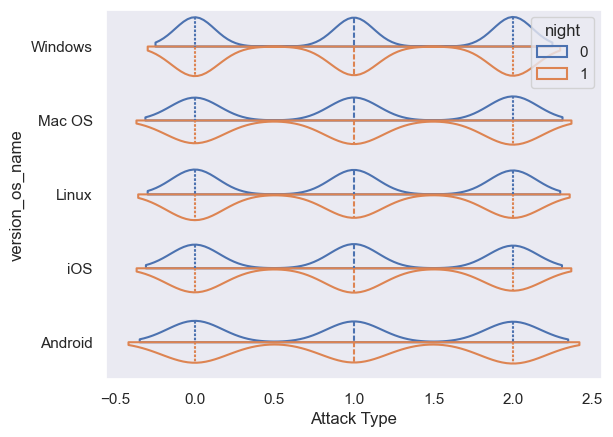

In [272]:
sns.set_theme(style="dark")

sns.violinplot(data=df, x="Attack Type", y="version_os_name", hue="night",
               split=True, inner="quart", fill=False)

<Axes: xlabel='Attack Type', ylabel='Anomaly Scores'>

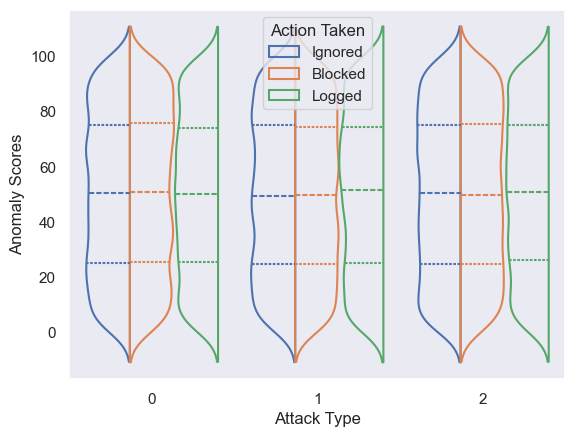

In [273]:
sns.set_theme(style="dark")

sns.violinplot(data=df, x="Attack Type", y="Anomaly Scores", hue="Action Taken",
               split=True, inner="quart", fill=False)

<Axes: xlabel='Attack Type', ylabel='Anomaly Scores'>

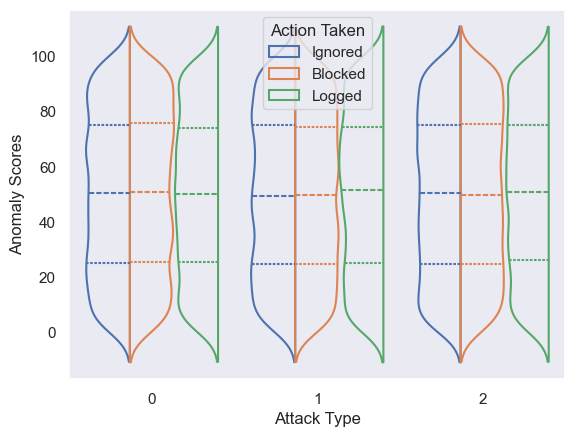

In [274]:
sns.violinplot(data=df, x="Attack Type", y="Anomaly Scores", hue="Action Taken",
               split=True, inner="quart", fill=False)